# Estudio de caso: muertes inusuales en México

> El siguiente estudio de caso ilustra cómo los datos *tidy* y las *tidy tools* facilitan el análisis de datos al facilitar las transiciones entre la manipulación, la visualización y el modelado. No verás ningún código que exista únicamente para obtener el output de una función en el formato correcto para que sea el input para otra.

> El estudio de caso utiliza datos de mortalidad a nivel individual de México. El objetivo es encontrar causas de muerte con patrones temporales inusuales dentro de un día.


## "Housekeeping"

In [1]:
import math
import textwrap

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import HuberRegressor

In [3]:
%matplotlib inline

In [4]:
sns.set()

## Load the Data

In [5]:

import pyreadr

deaths = pyreadr.read_r('data/deaths.rds')

# done! let's see what we got
print(deaths.keys()) # let's check what objects we got: there is only None
deaths = deaths[None] # extract the pandas data frame for the only object available
print(deaths.head())


odict_keys([None])
   yod  mod  dod  hod  cod
0    0    0    0  NaN  E14
1    0    0    0  NaN  E46
2    0    0    0  NaN  I21
3    0    0    0  NaN  K70
4    0    0    0  NaN  P21


In [6]:

deaths = deaths[(deaths["yod"] == 2008) & (deaths["mod"] != 0) & (deaths["dod"] != 0)]
deaths = deaths[~(deaths["hod"] < 0)]
deaths = deaths.reset_index(drop=True)

deaths.hod.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, nan], dtype=object)

In [7]:
deaths.shape

(527429, 5)

In [8]:
deaths.head()

,yod,mod,dod,hod,cod
0,2008,1,1,1,B20
1,2008,1,1,1,B22
2,2008,1,1,1,C18
3,2008,1,1,1,C34
4,2008,1,1,1,C50


In [9]:
# The file contains 7 duplicates that are discarded.
codes = pd.read_csv("data/icd-main.csv")
codes = codes[(codes["code"] != codes["code"].shift())].set_index("code")

In [10]:
codes.shape

(1851, 1)

In [11]:
codes.head()

,disease
code,
A00,Cholera
A01,Typhoid and paratyphoid fevers
A02,Other salmonella infections
A03,Shigellosis
A04,Other bacterial intestinal infections


## Counts

Cuenta el número de muertos por `"hod"` (="hour of the day") y `"cod"` (="cause of death"), y también hace un `join` con las etiquetas que son más descriptivas para las varias causas.

In [12]:
counts = (
    pd.DataFrame(deaths.groupby(["hod", "cod"]).size(), columns=["freq"])
    .reset_index()
    .join(codes, on="cod")
)
# This is to ensure that no duplicates are created
# because of duplicate entries in the codes DataFrame.
assert counts["cod"].value_counts().max() <= 24

# Keep only causes where a death happened in every hour.
counts = counts[counts["cod"].isin(list((counts["cod"].value_counts() == 24).index))]

counts.head()

,hod,cod,freq,disease
0,1,A01,3,Typhoid and paratyphoid fevers
1,1,A02,3,Other salmonella infections
2,1,A04,7,Other bacterial intestinal infections
3,1,A05,1,"Other bacterial foodborne intoxications, not e..."
4,1,A06,2,Amebiasis


Añade una columna `"prop"` (="proportion") indicando la frecuencia relativa de una determinada causa de muerte por horas.

In [13]:
counts = counts.set_index("cod")
counts["prop"] = counts["freq"] / deaths.groupby(["cod"]).size().reindex(counts.index)
counts = counts.reset_index()
# Re-order the columns as in the paper.
counts = counts[["hod", "cod", "freq", "disease", "prop"]]

counts.head()

,hod,cod,freq,disease,prop
0,1,A01,3,Typhoid and paratyphoid fevers,0.062500
1,1,A02,3,Other salmonella infections,0.046875
2,1,A04,7,Other bacterial intestinal infections,0.048951
3,1,A05,1,"Other bacterial foodborne intoxications, not e...",0.050000
4,1,A06,2,Amebiasis,0.022989


Añade las columnas `"freq_all"` y `"prop_all"`, que muestran el número absoluto de muertes para una hora determinada del día (sin tener en cuenta la causa de la muerte), y la proporción de muertes de una determinada hora del día con respecto al día completo.

In [14]:
counts = counts.set_index("hod")
counts["freq_all"] = deaths.groupby("hod").size()
counts["prop_all"] = counts["freq_all"] / deaths.shape[0]
counts = counts.reset_index()

counts.head()

,hod,cod,freq,disease,prop,freq_all,prop_all
0,1,A01,3,Typhoid and paratyphoid fevers,0.062500,20038,0.037992
1,1,A02,3,Other salmonella infections,0.046875,20038,0.037992
2,1,A04,7,Other bacterial intestinal infections,0.048951,20038,0.037992
3,1,A05,1,"Other bacterial foodborne intoxications, not e...",0.050000,20038,0.037992
4,1,A06,2,Amebiasis,0.022989,20038,0.037992


## Distancia entre patrones temporales

> A continuación calculamos una distancia entre el patrón temporal de cada causa de muerte y el patrón temporal general. Hay muchas maneras de medir esta distancia, pero encontré que una simple desviación cuadrática media es reveladora. También registramos el tamaño de la muestra, el número total de muertes por esa causa. Para asegurarnos de que las enfermedades que consideramos sean suficientemente representativas, solo trabajaremos con enfermedades con más de 50 muertes totales (∼2/hora).

In [15]:
devi = (
    codes.join(deaths.groupby("cod").count()["yod"].to_frame(), how="inner")
    .join(
        counts.groupby("cod")
        .apply(lambda x: ((x["prop"] - x["prop_all"]) ** 2).mean())
        .to_frame(),
        how="inner",
    )
    .rename(columns={"yod": "n", 0: "dist"})
)
devi = devi[(devi["n"] > 50)]

devi.head()

,disease,n,dist
A02,Other salmonella infections,64,0.000692
A04,Other bacterial intestinal infections,143,0.000191
A06,Amebiasis,87,0.000360
A09,Diarrhea and gastroenteritis of infectious origin,3114,0.000027
A16,"Respiratory tuberculosis, not confirmed bacter...",1709,0.000027


Grafica `"dist"` vs. `"n"`. No se aprecia mucho en este gráfico.

<AxesSubplot:xlabel='n', ylabel='dist'>

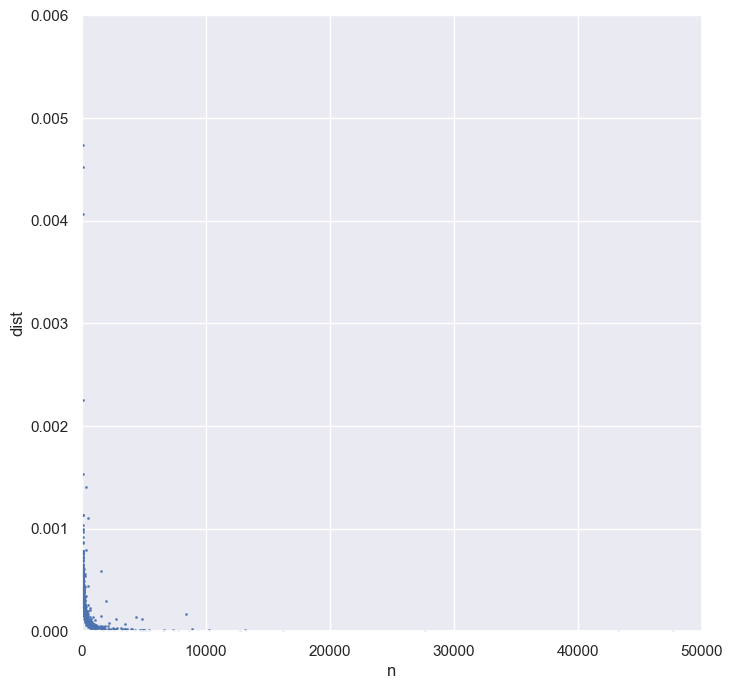

In [16]:
_, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, 50000)
ax.set_ylim(0, 0.006)
sns.regplot(x="n", y="dist", data=devi, ax=ax, fit_reg=False, scatter_kws={"s": 1})

La relación se vuelve más obvia si uno grafica los mimos puntos en una escala `"log"`-`"log"`.

<AxesSubplot:xlabel='n', ylabel='dist'>

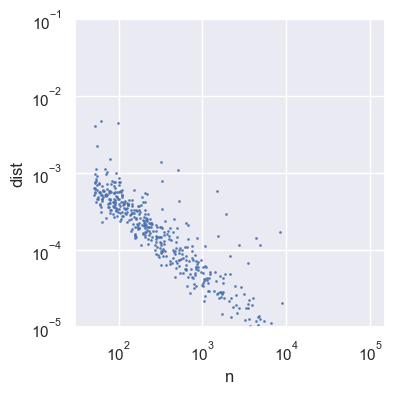

In [17]:
_, ax = plt.subplots(figsize=(4, 4))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(30, 150000)
ax.set_ylim(0.00001, 0.1)
sns.regplot(x="n", y="dist", data=devi, ax=ax, fit_reg=False, scatter_kws={"s": 1})

> Estamos interesados en puntos que tienen valores de `y` altos, en relación con sus vecinos de `x`.   
> Controlando por el número de muertes, estos puntos representan las enfermedades que más se apartan del patrón general.  
>  Para encontrar estos puntos inusuales, ajustamos un modelo lineal robusto y graficamos los residuos, Figura 3.   
> El gráfico muestra una región vacía alrededor de un residuo de 1,5.   
> Entonces, de manera un tanto arbitraria, seleccionaremos aquellas enfermedades con un residuo mayor a 1.5.


In [18]:
# Note that the HuberRegressor is not the exact
# same method as in the paper but close.
X = np.log(devi["n"]).values[:, np.newaxis]
y = np.log(devi["dist"]).values
rlm = HuberRegressor()
rlm.fit(X, y)
devi["residuals"] = y - rlm.predict(X)

Graficamos el umbral de muertes "inusuales", establecido arbitrariamente en 1.5

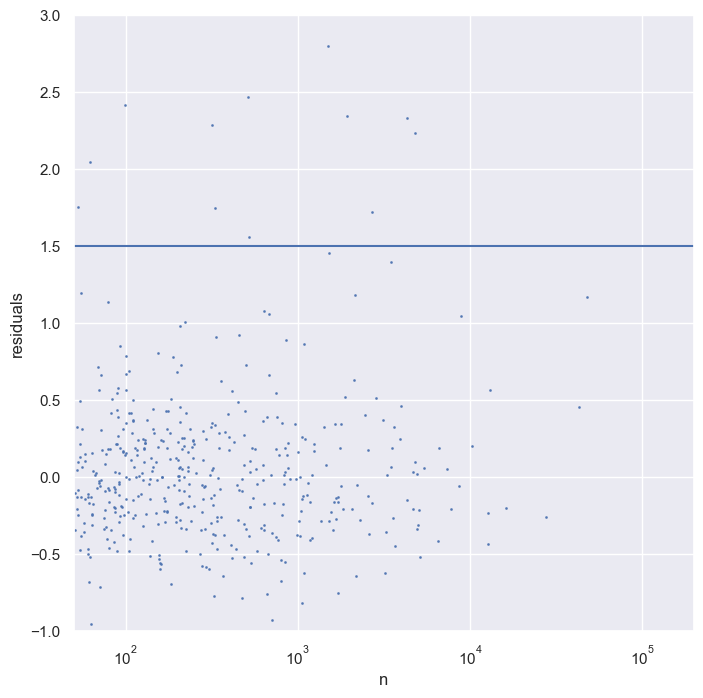

In [19]:
_, ax = plt.subplots(figsize=(8, 8))
ax.set_xscale("log")
ax.set_xlim(50, 200000)
ax.set_ylim(-1, 3)
sns.regplot(x="n", y = "residuals", data=devi, ax=ax, fit_reg=False, scatter_kws={"s": 1})
ax.hlines(1.5, 0, 200000)

> Finalmente, graficamos el curso temporal de cada causa inusual, Figura 4.   
> Dividimos las enfermedades en dos gráficos debido a las diferencias en la variabilidad.  
>  La gráfica superior muestra enfermedades con más de 350 muertes y la inferior con menos de 350.  
>  Las causas de muerte se dividen en tres grupos principales: las relacionadas con asesinato, con ahogamiento y con transporte.   
> Los asesinatos son más comunes por la noche, los ahogamientos por la tarde y las muertes relacionadas con el transporte durante los viajes diarios.  
>  La línea naranja en el fondo muestra el curso temporal de todas las enfermedades.

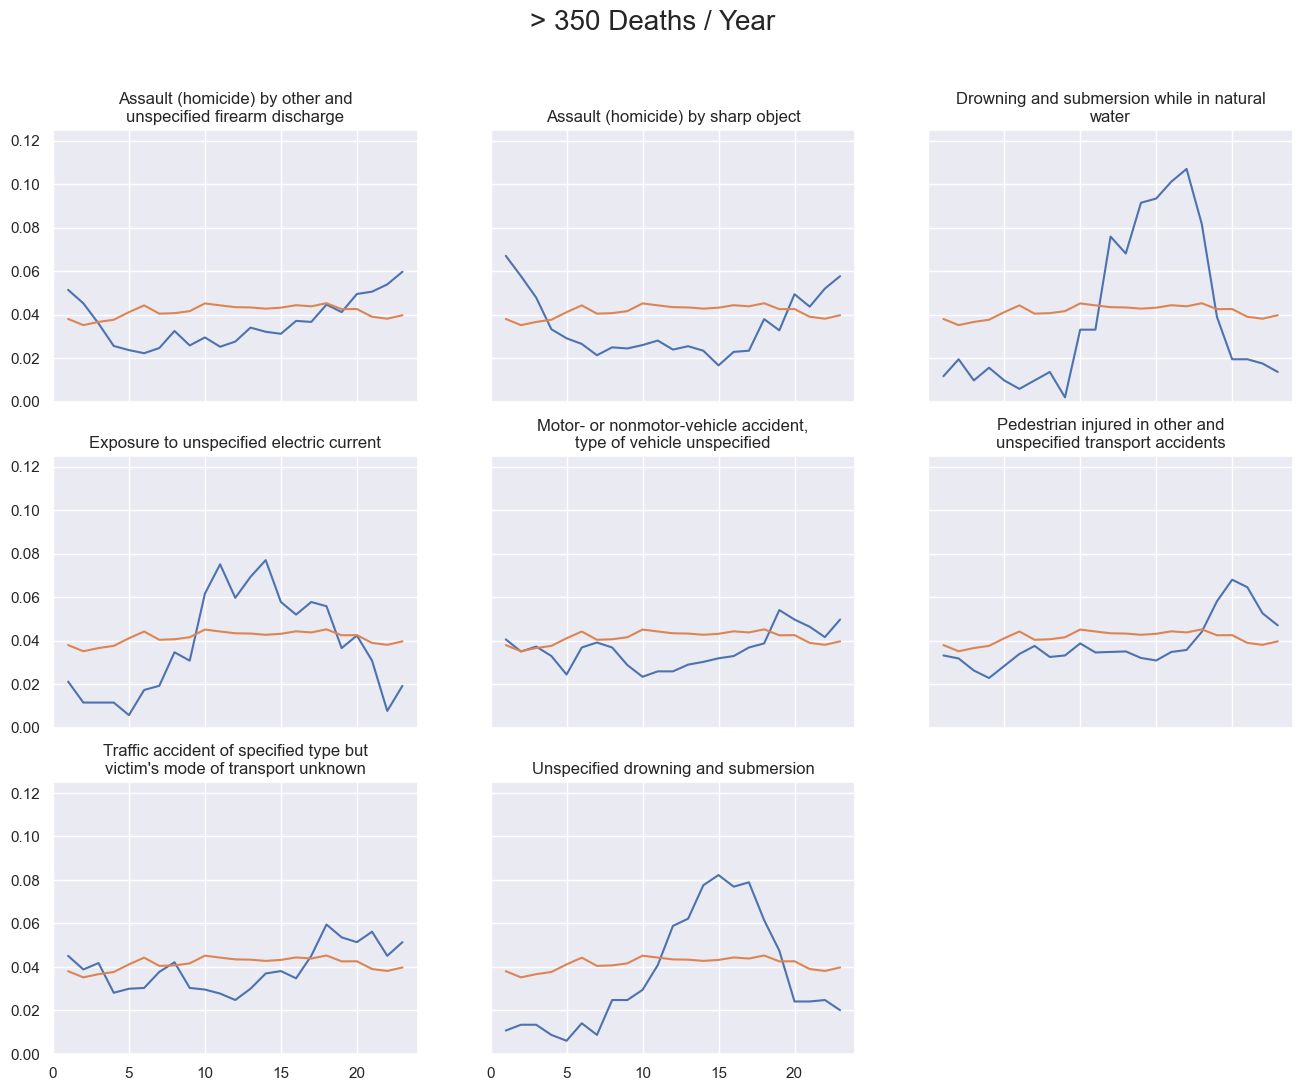

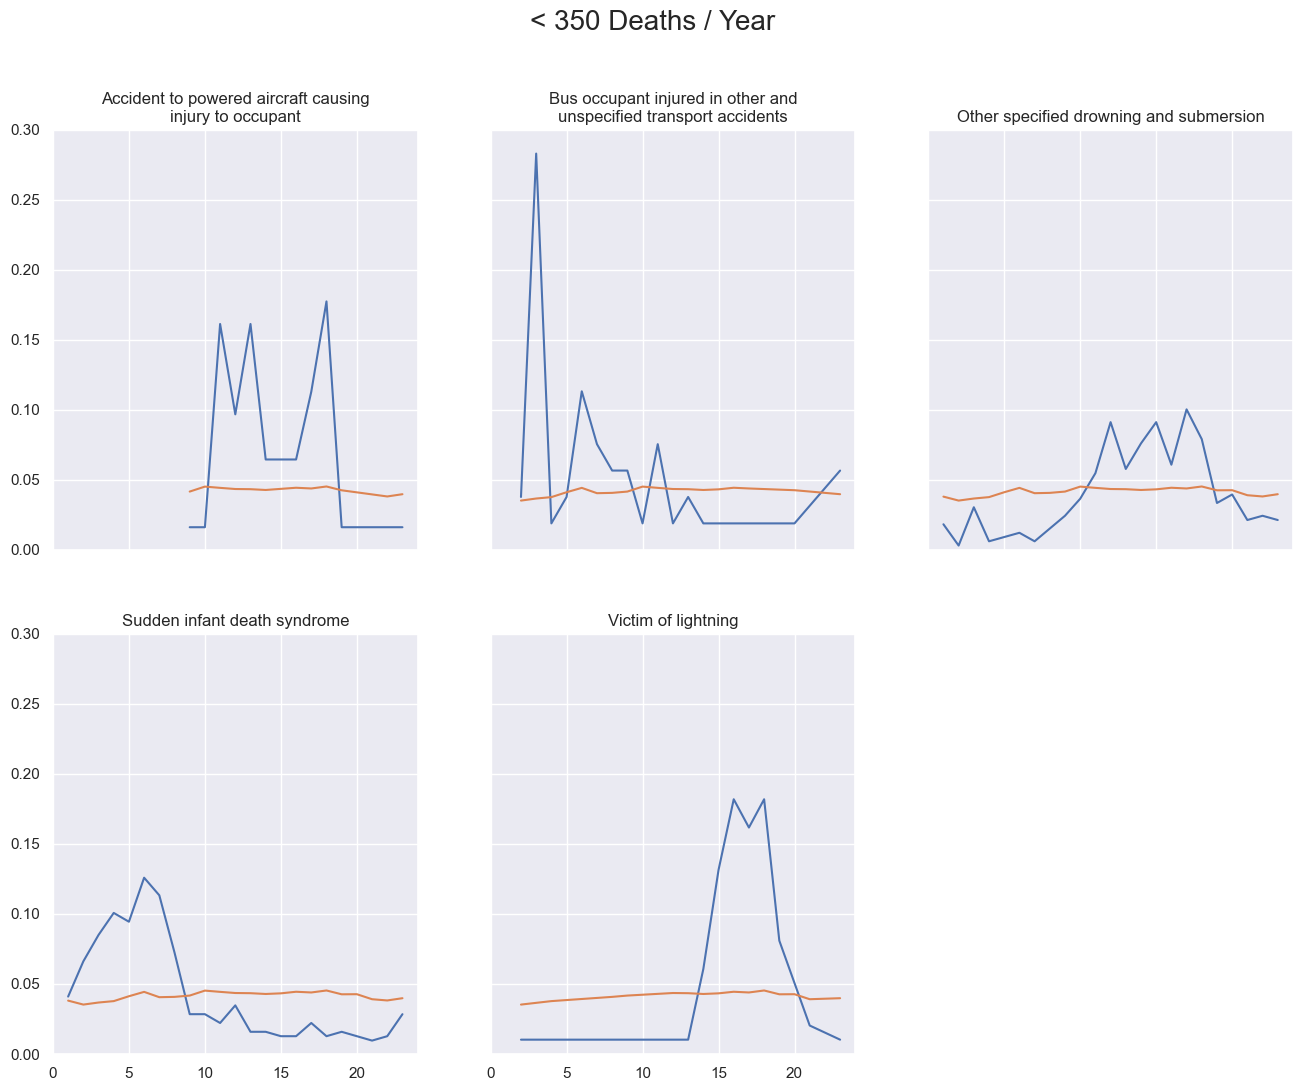

In [20]:
# Get all temporarily "unusual" deaths.
unusual = devi.loc[(devi["residuals"] > 1.5), ["disease", "n"]].sort_values("disease")
# Helper dataset for easy indexing / value retrieval.
plot_data = counts[["cod", "hod", "prop", "prop_all"]].set_index("cod")
# Divide the plots in two big categories.
for header, cond, ylim in [
    ("> 350 Deaths / Year", (unusual["n"] > 350), 0.125),
    ("< 350 Deaths / Year", (unusual["n"] <= 350), 0.3),
]:
    nrows = math.ceil(len(unusual[cond]) / 3)
    fig = plt.figure(figsize=(16, 12),)
    for i, (cod, (disease, _)) in enumerate(unusual[cond].iterrows(), 1):
        ax = fig.add_subplot(nrows, 3, i)
        ax.set_title("\n".join(textwrap.wrap(disease, 40)))
        ax.set_xlim(0, 24)
        ax.set_ylim(0, ylim)
        ax.plot(plot_data.loc[cod, "hod"], plot_data.loc[cod, "prop"])
        ax.plot(plot_data.loc[cod, "hod"], plot_data.loc[cod, "prop_all"])
        # Show only lower and left axes.
        if i not in (3 * nrows - 2, 3 * nrows - 1, 3 * nrows):
            plt.setp(ax.get_xticklabels(), visible=False)
        if i % 3 != 1:
            plt.setp(ax.get_yticklabels(), visible=False)
    fig.suptitle(header, fontsize=20)